# Analysing eCommerce Data

## Table of Contents  
* 
    * [Part 1 : Working with RDD](#part-1)  
        * [1.1 Data Preparation and Loading](#1.1)  
        * [1.2 Data Partitioning in RDD](#1.2)  
        * [1.3 Query/Analysis](#1.3)  
    * [Part 2 : Working with DataFrames](#2-dataframes)  
        * [2.1 Data Preparation and Loading](#2-dataframes)  
        * [2.2 Query/Analysis](#2.2)  
    * [Part 3 :  RDDs vs DataFrame vs Spark SQL](#part-3)

# Part 1 : Working with RDDs <a class="anchor" name="part-1"></a>
## 1.1 Working with RDD
In this section, we create RDDs from the given datasets, perform partitioning in these RDDs and use various RDD operations to answer the queries for retail analysis. 

### 1.1.1 Data Preparation and Loading <a class="anchor" name="1.1"></a>
We write the code to create a SparkContext object using SparkSession. To create a SparkSession you first we need to build a SparkConf object that contains information about your application. 

In [95]:
# Import classes into program
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession

# setting number of CPU cores to be used. * indicates all available cores
master = "local[*]"
# name of application
app_name = "Assignment 1 RDD"
# setting spark config variable
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# SparkSession builder
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

In [96]:
# RDD for Application Data Excel 
application_data_rdd = sc.textFile('data/application_data.csv')
# RDD for Previous Application Data Excel 
previous_application_rdd = sc.textFile('data/previous_application.csv')
# RDD for Values Dictionary Data Excel 
value_dict_rdd = sc.textFile('data/value_dict.csv')

- For each RDD, remove the header rows and display the total count and first 10 records. 

In [97]:
#Removing headers from the RDDs by zipping them with Index and getting rid of all values in index 0 i.e. the headers.
application_data_rdd_no_header = application_data_rdd.zipWithIndex().filter(lambda row_index: row_index[1] > 0).keys()
previous_application_rdd_no_header = previous_application_rdd.zipWithIndex().filter(lambda row_index: row_index[1] > 0).keys()
value_dict_rdd_no_header = value_dict_rdd.zipWithIndex().filter(lambda row_index: row_index[1] > 0).keys()

print(f"Application Data Count: {application_data_rdd_no_header.count()}")
# application_data_rdd_no_header.take(10)

print(f"Previous Application Data Count: {previous_application_rdd_no_header.count()}")
# previous_application_rdd_no_header.take(10)

print(f"Value Dict Data Count: {value_dict_rdd_no_header.count()}")
# value_dict_rdd_no_header.take(10)

Application Data Count: 172591
Previous Application Data Count: 935037
Value Dict Data Count: 126


- Drop the following columns from RDDs:  
    - previous_application: sellerplace_area, name_seller_industry  
    - application_data: All columns start with flag_ and amt_credit_req_(except for amt_credit_req_last_year).

In [99]:
#mapping the RDD and selecting only the required columns using their indices
application_data_rdd_new = application_data_rdd_no_header.map(lambda x: [x.split(",")\
    [i] for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,25,26,27,28,29,30,31,\
                  32,33,39]])
previous_application_data_rdd_new = previous_application_rdd_no_header.map(lambda x: \
    [x.split(",")[i] for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,\
                               21,24,25,26,27,28,29,30,31,32,33]])


### 1.2 Data Partitioning in RDD <a class="anchor" name="1.2"></a>
1.2.1 For each RDD, we print out the total number of partitions and the number of records in each partition. Answer the following questions:   
How many partitions do the above RDDs have?   
How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy?   
Can you explain why it will be partitioned in this number? If I only have one single-core CPU on my PC, what is the default partition's number? (Hint: search the Spark source code to try to answer this question.)   
Write the code and your explanation in Markdown cells.

The default partitioning strategy in Spark is based on the number of available cores in the cluster. When you create an RDD in Spark without specifying a partitioning strategy, Spark uses a default hash partitioning strategy called Random Equal Partitioning.

The spark.default.parallelism configuration parameter establishes the default number of partitions and is depending on the resources (e.g., CPU core count) on the Spark cluster. 

For a single core CPU, the default number of partitions may be set just 1. We can check the 'getOrCreate' method in pyspark/context.py to see how this configuration is determined.

We can explicitly set the 'spark.default.parallelism' value in Spark configurations, however by default it is set based on the available resources(CPU cores).

In [100]:
from pyspark.rdd import RDD

# Function to print the partitions
def print_partitions(data):
    # to check if 'data' is an instance of RDD
    if isinstance(data, RDD):
        numPartitions = data.getNumPartitions()
        partitions = data.glom().collect()
    # else if 'data' is not an RDD
    else:
        numPartitions = data.rdd.getNumPartitions()
        partitions = data.rdd.glom().collect()
    
    # Loop to print the index of the partition and number of records
    for index, partition in enumerate(partitions):
        # show partition if it is not empty
        if len(partition) > 0:
            print(f"Partition {index}: {len(partition)} records")

print("Number of partitions in Application Data:{}".\
      format(application_data_rdd_new.getNumPartitions()))
print_partitions(application_data_rdd_new)  

print("Number of partitions in Previous Application Data:{}".\
      format(previous_application_data_rdd_new.getNumPartitions()))
print_partitions(previous_application_data_rdd_new)  

Number of partitions in Application Data:2
Partition 0: 86272 records
Partition 1: 86319 records
Number of partitions in Previous Application Data:6
Partition 0: 167804 records
Partition 1: 163835 records
Partition 2: 162603 records
Partition 3: 162683 records
Partition 4: 162437 records
Partition 5: 115675 records


- We create a UDF function that takes two parameters: a date and an integer value, and returns a date. Assuming all applications are made on 1/Jan/2024, create a new column named decision_date, use the UDF function to fill its values from days_decisions.

In [103]:
from datetime import datetime, timedelta
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# User Defined Function to get date from Number of Days
def date_converter(date, num):
    return datetime.strptime(date, "%d%m%Y").date() + timedelta(days=num)   

# date_converter_udf = udf(date_converter, StringType())

previous_application_data_rdd_new_with_col = previous_application_data_rdd_new.\
map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],\
               x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],x[21],x[22],\
               x[23],x[24],x[25],x[26],x[27],x[28],x[29],x[30],x[31], \
               date_converter("01012024", int(x[13]))))

- We join application_data and previous_application with value_dict and replace integer values with string values from the dictionary.

In [48]:
#organization type
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==1)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Business Entity Type 2",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==2)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Agriculture",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==3)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Industry: type 13",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==4)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Religion",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==5)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Construction",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==6)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Police",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==7)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Culture",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==8)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Transport: type 1",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==9)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Other",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==10)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Realtor",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==11)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Business Entity Type 1",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==12)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Industry : type 8",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==13)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Insurance",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==14)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Industry : type 2",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==15)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Transport : type 2",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==16)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Security Ministries",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2 
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==17)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Industry : type 1",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==18)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Postal",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==19)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Industry : type 10",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==20)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"University : type 3",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==21)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Trade",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==22)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Medicine",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==23)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Cleaning",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==24)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Industry : type 4",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==25)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Transport : type 3",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==26)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Mobile",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==27)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Security",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==28)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Government",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==29)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Industry : type 7",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==30)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"School",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==31)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"XNA",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==32)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Industry : type 11",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==33)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Telecom",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==34)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Trade : type 1",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==35)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Industry : type 3",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==36)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Business Entity Type 3",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2 
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==37)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Trade : type 4",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==38)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Transport : type 4",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==39)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Bank",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==40)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Advertising",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==41)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Trade : type 6",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==42)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Trade : type 7",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==43)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Restaurant",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==44)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Trade : type 2",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==45)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Industry : type 5",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==46)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Industry : type 6",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==47)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Legal Services",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==48)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Trade : type 5",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==49)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Services",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==50)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Self-employed",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==51)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Hotel",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==52)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Electricity",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==53)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Industry: type 9",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==54)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Kindergarten",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==55)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Emergency",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==56)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Housing",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==57)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Industry: type 12",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[23])==58)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],"Military",x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2


#housingtype
temp1 = application_data_rdd_new.filter(lambda x: int(x[14])==1)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],"Rented apartment",x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[14])==2)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],"Co-op apartment",x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[14])==3)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],"Office apartment",x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[14])==4)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],"Municipal apartment",x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[14])==5)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],"With parents",x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[14])==6)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],"House / apartment",x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2

#education type
temp1 = application_data_rdd_new.filter(lambda x: int(x[12])==1)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],"Secondary / secondary special",x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[12])==2)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],"Incomplete higher",x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[12])==3)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],"Lower secondary",x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[12])==4)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],"Higher education",x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[12])==5)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],"Academic degree",x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2

#occupation_type
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==1)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Private service staff",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==2)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Realty agents",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==3)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Waiters/barmen staff",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==4)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"IT staff",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==5)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Managers",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==6)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Cleaning staff",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==7)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Cooking staff",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==8)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Security staff",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==9)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Drivers",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==10)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Accountants",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==11)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Medicine staff",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==12)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Laborers",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==13)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Secretaries",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==14)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"HR staff",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==15)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"High skill tech staff",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==16)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Sales staff",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==17)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Low-skill Laborers",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==18)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[19])==19)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],"Core staff",x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2

#income type
temp1 = application_data_rdd_new.filter(lambda x: int(x[11])==1)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],"State servant",x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[11])==2)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],"Working",x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[11])==3)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],"Student",x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[11])==4)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],"Maternity leave",x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[11])==5)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],"Pensioner",x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[11])==6)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],"Businessman",x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[11])==7)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],"Unemployed",x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[11])==8)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],"Commercial associate",x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2

#family status
temp1 = application_data_rdd_new.filter(lambda x: int(x[13])==1)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],"Unknown",x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[13])==2)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],"Civil marriage",x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[13])==3)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],"Married",x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[13])==4)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],"Separated",x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[13])==5)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],"Widow",x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[13])==6)
temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],"Single / not married",x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2

#contract type
temp1 = application_data_rdd_new.filter(lambda x: int(x[2])==1)
temp2=temp1.map(lambda x: (x[0],x[1],"XNA",x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[2])==2)
temp2=temp1.map(lambda x: (x[0],x[1],"Revolving loans",x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[2])==3)
temp2=temp1.map(lambda x: (x[0],x[1],"Cash loans",x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2
temp1 = application_data_rdd_new.filter(lambda x: int(x[2])==4)
temp2=temp1.map(lambda x: (x[0],x[1],"Consumer loans",x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],float(x[17]),x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28]))
application_data_rdd_new = temp2

# #channel type
# temp1 = previous_application_data_rdd_new_with_col.filter(lambda x: int(x[21])==1)
# temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],int(x[4]),x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],"Contact center",x[22],x[23],x[24],x[25],x[26],x[27],x[28],x[29],x[30],x[31], datetime.date(x[32])))
# previous_application_data_rdd_new_with_col = temp2
# temp1 = previous_application_data_rdd_new_with_col.filter(lambda x: int(x[21])==2)
# temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],int(x[4]),x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],"Car dealer",x[22],x[23],x[24],x[25],x[26],x[27],x[28],x[29],x[30],x[31], datetime.date(x[32])))
# previous_application_data_rdd_new_with_col = temp2
# temp1 = previous_application_data_rdd_new_with_col.filter(lambda x: int(x[21])==3)
# temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],int(x[4]),x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],"Country-wide",x[22],x[23],x[24],x[25],x[26],x[27],x[28],x[29],x[30],x[31], datetime.date(x[32])))
# previous_application_data_rdd_new_with_col = temp2
# temp1 = previous_application_data_rdd_new_with_col.filter(lambda x: int(x[21])==4)
# temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],int(x[4]),x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],"Stone",x[22],x[23],x[24],x[25],x[26],x[27],x[28],x[29],x[30],x[31], datetime.date(x[32])))
# previous_application_data_rdd_new_with_col = temp2
# temp1 = previous_application_data_rdd_new_with_col.filter(lambda x: int(x[21])==5)
# temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],int(x[4]),x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],"Regional / Local",x[22],x[23],x[24],x[25],x[26],x[27],x[28],x[29],x[30],x[31], datetime.date(x[32])))
# previous_application_data_rdd_new_with_col = temp2
# temp1 = previous_application_data_rdd_new_with_col.filter(lambda x: int(x[21])==6)
# temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],int(x[4]),x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],"Credit and cash offices",x[22],x[23],x[24],x[25],x[26],x[27],x[28],x[29],x[30],x[31], datetime.date(x[32])))
# previous_application_data_rdd_new_with_col = temp2
# temp1 = previous_application_data_rdd_new_with_col.filter(lambda x: int(x[21])==7)
# temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],int(x[4]),x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],"Channel of corporate sales",x[22],x[23],x[24],x[25],x[26],x[27],x[28],x[29],x[30],x[31], datetime.date(x[32])))
# previous_application_data_rdd_new_with_col = temp2
# temp1 = previous_application_data_rdd_new_with_col.filter(lambda x: int(x[21])==8)
# temp2=temp1.map(lambda x: (x[0],x[1],x[2],x[3],int(x[4]),x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],"AP+ (Cash loan)",x[22],x[23],x[24],x[25],x[26],x[27],x[28],x[29],x[30],x[31],datetime.date(x[32])))
# previous_application_data_rdd_new_with_col = temp2

### 1.3 Query/Analysis <a class="anchor" name="1.3"></a>
For this part, we write relevant RDD operations to answer the following queries.

**Calculate the total approved loan amount for each year, each month.**

In [104]:
#Extracting Credit_amount and Date fields from Previous APplication RDD
final_vals = previous_application_data_rdd_new_with_col.map(\
                lambda x: (float(x[4]), x[32]))

# Function to extract Month and Year from Date Field 
# And to return a key value pair where Key is (Year, Month)
# Value is the amount credit
def extract_month_year_amount(row):
    year_month = (row[1].year, row[1].month)
    return (year_month, row[0])

# Using the above defined function in the RDD
key_value_rdd = final_vals.map(extract_month_year_amount)

#  Using reduceByKey to get sum of Amount of Credit by Date values
total_amount_rdd = key_value_rdd.reduceByKey(lambda x, y: x + y)

# Print the results
result = total_amount_rdd.collect()
print("YEAR   |   MONTH   |   AMOUNT")
for (year, month), total_amount in result:
    print(f"{year}   |   {month}   |   {total_amount}")

YEAR   |   MONTH   |   AMOUNT
2022   |   12   |   5840286516.582
2023   |   9   |   3203379258.4809995
2023   |   3   |   6065511687.095999
2016   |   8   |   310211626.5
2021   |   7   |   3008879414.207
2020   |   10   |   1350087673.49
2021   |   11   |   3851682941.227
2022   |   2   |   4139099082.6910005
2016   |   2   |   207320737.5
2020   |   6   |   990385190.1240002
2017   |   3   |   431919045.0
2016   |   4   |   238195408.5
2019   |   9   |   603760104.0
2019   |   7   |   543983625.21
2018   |   12   |   347239281.194
2018   |   10   |   319896089.056
2023   |   6   |   6341937043.455999
2022   |   11   |   5342236684.441999
2023   |   4   |   6026725724.797999
2019   |   12   |   798546613.37
2022   |   9   |   5012816742.969
2022   |   7   |   5018366493.81
2017   |   10   |   371486455.694
2022   |   5   |   4688188815.190001
2021   |   2   |   1859628881.578
2017   |   8   |   387029743.96199995
2017   |   4   |   434565675.0
2018   |   5   |   285565511.83000004
201

**For each hour when the applications start (0-23), print the percentage ratio of application cancellation.**

In [105]:
# Getting hour value along with Boolean if Loan application
# is approved or not
final_vals = previous_application_data_rdd_new_with_col.map(\
                lambda x: (int(x[7]), True if x[12]=="Canceled" \
                           else False))

# Using reduceByKey and map to get sum of cancellations 
total_counts_rdd = final_vals.map(lambda x: (x[0], (1, int(x[1]))))\
.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

# Function to calculate the cancellation percentage
def calculate_percentage_ratio(row):
    hour = row[0]
    total_applications, cancellations = row[1]
    percentage_ratio = (cancellations / total_applications) \
    * 100 if total_applications > 0 else 0
    return (hour, percentage_ratio)

# Getting an RDD with hour and Cancellation Percentage
percentage_ratio_rdd = total_counts_rdd.map(calculate_percentage_ratio)

result = percentage_ratio_rdd.collect()

# Printing the result
for hour, percentage_ratio in result:
    print(f"Hour: {hour}, Cancellation Percentage: \
    {percentage_ratio:.2f}%")


Hour: 12, Cancellation Percentage:     18.78%
Hour: 6, Cancellation Percentage:     22.48%
Hour: 18, Cancellation Percentage:     14.32%
Hour: 0, Cancellation Percentage:     11.86%
Hour: 13, Cancellation Percentage:     18.17%
Hour: 7, Cancellation Percentage:     22.44%
Hour: 19, Cancellation Percentage:     10.29%
Hour: 1, Cancellation Percentage:     31.20%
Hour: 8, Cancellation Percentage:     20.61%
Hour: 14, Cancellation Percentage:     18.08%
Hour: 20, Cancellation Percentage:     7.29%
Hour: 2, Cancellation Percentage:     37.85%
Hour: 9, Cancellation Percentage:     22.20%
Hour: 15, Cancellation Percentage:     17.79%
Hour: 21, Cancellation Percentage:     10.34%
Hour: 3, Cancellation Percentage:     31.75%
Hour: 10, Cancellation Percentage:     21.44%
Hour: 4, Cancellation Percentage:     26.31%
Hour: 16, Cancellation Percentage:     17.52%
Hour: 22, Cancellation Percentage:     18.16%
Hour: 17, Cancellation Percentage:     16.71%
Hour: 11, Cancellation Percentage:     19.65

## Part 2. Working with DataFrames <a class="anchor" name="2-dataframes"></a>
In this section, we will need to load the given datasets into PySpark DataFrames and use DataFrame functions.

### 2.1 Data Preparation and Loading


In [106]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# Converting Excel Files into Spark Dataframes
df_previous_application = spark.read.csv("data/previous_application.csv", header=True)
df_application_data = spark.read.csv("data/application_data.csv", header=True)

**Displaying the schema of all dataframes.**

In [108]:
# Printing Dataframes Schema
df_previous_application.printSchema()

df_application_data.printSchema()

root
 |-- id_app: string (nullable = true)
 |-- contract_type: string (nullable = true)
 |-- amt_annuity: string (nullable = true)
 |-- amt_application: string (nullable = true)
 |-- amt_credit: string (nullable = true)
 |-- amt_down_payment: string (nullable = true)
 |-- amt_goods_price: string (nullable = true)
 |-- hour_appr_process_start: string (nullable = true)
 |-- rate_down_payment: string (nullable = true)
 |-- rate_interest_primary: string (nullable = true)
 |-- rate_interest_privileged: string (nullable = true)
 |-- name_cash_loan_purpose: string (nullable = true)
 |-- name_contract_status: string (nullable = true)
 |-- days_decision: string (nullable = true)
 |-- name_payment_type: string (nullable = true)
 |-- code_rejection_reason: string (nullable = true)
 |-- name_type_suite: string (nullable = true)
 |-- name_client_type: string (nullable = true)
 |-- name_goods_category: string (nullable = true)
 |-- name_portfolio: string (nullable = true)
 |-- name_product_type: str

### 2.2 QueryAnalysis  <a class="anchor" name="2.2"></a>
We implement the following queries using dataframes. 

**Calculate the average income for each education_type group, and print the result.**

In [109]:
from pyspark.sql.functions import avg,col

# Getting Average Income by Education Type
avg_income = df_application_data.groupBy("education_type").agg(\
                avg("income_total")).orderBy("education_type")

avg_income.show()

+--------------+------------------+
|education_type| avg(income_total)|
+--------------+------------------+
|             1|155155.73917756812|
|             2| 181014.4486888112|
|             3| 128151.7258064516|
|             4|209339.63911283418|
|             5|          227110.0|
+--------------+------------------+



**Find the applicants who made credit requests last year with an average credit score of less than 0.5 from the three credit rating sources.**

In [111]:
# Replacing all null values as mentioned in question
df_replace_null = df_application_data.fillna(0.5)

# FIlter Dataframe for all values of amt_credit_req_last_year > 0
df_lastyear = df_replace_null.filter(col("amt_credit_req_last_year") > 0)

# Adding new Column with average credit score
df_last_year_credit = df_lastyear.withColumn("avg_credit", \
            (col("credit_score_1") + col("credit_score_2") + \
             col("credit_score_3")) / 3)
df_low_credit = df_last_year_credit.filter(col("avg_credit") < 0.5)

# Printing the data
df_low_credit.select("id_app", "amt_credit_req_last_year", \
                     "avg_credit").orderBy("avg_credit").show()

+------+------------------------+--------------------+
|id_app|amt_credit_req_last_year|          avg_credit|
+------+------------------------+--------------------+
|235139|                     2.0|0.042671069666666665|
|128079|                     4.0|         0.043409467|
|223200|                     1.0|0.048391312333333325|
|272483|                     1.0| 0.05119255043333334|
|125091|                     2.0|0.062085257033333334|
|236551|                     2.0| 0.06363488966666668|
|296838|                     3.0|         0.065800548|
|231478|                     3.0| 0.06676471666666665|
|299760|                     7.0|        0.0693554446|
|294957|                     4.0| 0.07026440333333332|
|106699|                     1.0| 0.07316274856666666|
|192556|                     4.0|         0.074818367|
|260993|                     1.0| 0.07717986266666667|
|127569|                     3.0| 0.07772445809999999|
|163880|                     8.0| 0.07954736666666667|
|228977|  

**Transform the 'days_birth' column in the application_data to age(integer rounded down) and date_of_birth.**

In [112]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DateType
from datetime import date, timedelta

# Creating a UDF version of the date conversion function
date_converter_udf = F.udf(date_converter, DateType())

# Adding date of birth using days birth column
df_date_of_birth = df_application_data.withColumn("date_of_birth", \
    date_converter_udf(F.lit("01012024"), (F.col("days_birth")\
                                        .cast(IntegerType()))))
# df_age_data = df_date_of_birth.withColumn("age", (int((datetime.
# now() - datetime(2024, 1, 1) + timedelta(days=col("days_birth")
# .cast(IntegerType()))).days / 365)).cast(IntegerType()))

# Adding Age using days birth column
df_age_data = df_date_of_birth.withColumn("age", (F.abs(F.floor\
        (F.col("days_birth") / 365.2425))-1).cast(IntegerType()))

# displaying data and schema
df_age_data.select("id_app","date_of_birth","age","days_birth").\
            orderBy("id_app").show()
df_age_data.printSchema()


+------+-------------+---+----------+
|id_app|date_of_birth|age|days_birth|
+------+-------------+---+----------+
|100002|   1998-02-05| 25|     -9461|
|100003|   1978-02-06| 45|    -16765|
|100004|   1971-11-09| 52|    -19046|
|100006|   1971-12-20| 52|    -19005|
|100007|   1969-06-06| 54|    -19932|
|100008|   1977-08-14| 46|    -16941|
|100009|   1986-04-12| 37|    -13778|
|100010|   1972-05-23| 51|    -18850|
|100011|   1968-12-21| 55|    -20099|
|100012|   1984-05-21| 39|    -14469|
|100014|   1996-01-31| 27|    -10197|
|100015|   1968-02-07| 55|    -20417|
|100016|   1987-03-17| 36|    -13439|
|100017|   1985-06-08| 38|    -14086|
|100018|   1984-01-28| 39|    -14583|
|100019|   2000-02-08| 23|     -8728|
|100020|   1988-08-06| 35|    -12931|
|100021|   1997-03-27| 26|     -9776|
|100022|   1975-06-29| 48|    -17718|
|100023|   1992-12-06| 31|    -11348|
+------+-------------+---+----------+
only showing top 20 rows

root
 |-- id_app: string (nullable = true)
 |-- target: string

**Using an age bucket of 10(0-10, 11-20, 21-30, etc..), compute the percentage of applicants owning a car and a property.**

In [114]:
from pyspark.sql.functions import ceil, col, when, count, sum

# Creating Clumn 'Age_buckets' to group ages 
df_age_data = df_age_data.withColumn("age_bucket", (F.ceil((F.col("age")) / 10)))

# Creating Boolean values of Y and N
df_age_data = df_age_data.withColumn("own_car", col("own_car") == "Y")
df_age_data = df_age_data.withColumn("own_property", col("own_property") == "Y")


df_age_data.select("id_app","date_of_birth","age","days_birth",\
    "age_bucket","own_car","own_property").orderBy("id_app").show()

# Calculating Ownership percentage
ownership_percentage = df_age_data.groupBy("age_bucket").\
agg((sum(when(col("own_car") == "true", 1).otherwise(0)) / \
     count("age_bucket") * 100).alias("car_ownership"), 
(sum(when(col("own_property") == "true", 1).otherwise(0)) / \
 count("age_bucket") * 100).alias("property_ownership"),
(sum(when((col("own_car") == "true") & (col("own_property") \
== "true"), 1).otherwise(0)) / count("age_bucket") * 100)\
    .alias("both_ownership"))

ownership_percentage.orderBy("age_bucket").show()

+------+-------------+---+----------+----------+-------+------------+
|id_app|date_of_birth|age|days_birth|age_bucket|own_car|own_property|
+------+-------------+---+----------+----------+-------+------------+
|100002|   1998-02-05| 25|     -9461|         3|  false|        true|
|100003|   1978-02-06| 45|    -16765|         5|  false|       false|
|100004|   1971-11-09| 52|    -19046|         6|   true|        true|
|100006|   1971-12-20| 52|    -19005|         6|  false|        true|
|100007|   1969-06-06| 54|    -19932|         6|  false|        true|
|100008|   1977-08-14| 46|    -16941|         5|  false|        true|
|100009|   1986-04-12| 37|    -13778|         4|   true|        true|
|100010|   1972-05-23| 51|    -18850|         6|   true|        true|
|100011|   1968-12-21| 55|    -20099|         6|  false|        true|
|100012|   1984-05-21| 39|    -14469|         4|  false|        true|
|100014|   1996-01-31| 27|    -10197|         3|  false|        true|
|100015|   1968-02-0

**Draw a barchart to show the total number of uncancelled applications from male/female in each year.**

[Row(gender='F', year='2016', count=26077), Row(gender='M', year='2016', count=13192), Row(gender='F', year='2017', count=32100), Row(gender='M', year='2017', count=15678), Row(gender='XNA', year='2017', count=4), Row(gender='F', year='2018', count=26452), Row(gender='M', year='2018', count=12824), Row(gender='F', year='2019', count=32654), Row(gender='M', year='2019', count=15486), Row(gender='XNA', year='2019', count=2), Row(gender='F', year='2020', count=42501), Row(gender='M', year='2020', count=20197), Row(gender='XNA', year='2020', count=1), Row(gender='F', year='2021', count=67022), Row(gender='M', year='2021', count=33106), Row(gender='XNA', year='2021', count=3), Row(gender='F', year='2022', count=102912), Row(gender='M', year='2022', count=51859), Row(gender='XNA', year='2022', count=3), Row(gender='F', year='2023', count=104288), Row(gender='M', year='2023', count=49086), Row(gender='XNA', year='2023', count=18)]
Years:['2016', '2017', '2018', '2019', '2020', '2021', '2022',

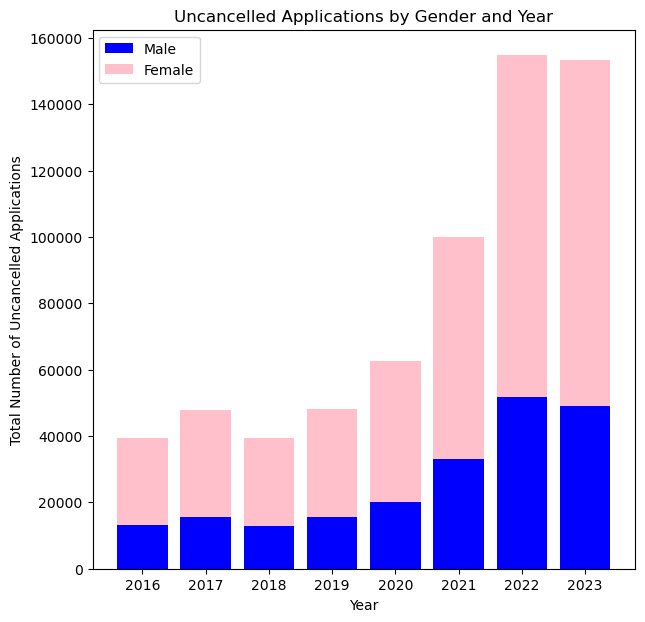

In [115]:
import matplotlib.pyplot as plt

# Joining Previous APplication and Age Data
df_joined = df_previous_application.join(df_age_data, \
            df_previous_application.id_app == df_age_data.id_app ,how="inner")

# Adding column with date
df_joined_with_date = df_joined.withColumn("date_of_application", \
            date_converter_udf(F.lit("01012024"), ((F.col("days_decision").\
                                    cast(IntegerType())))))

# Filtering for all Uncanceled applications
approved_applications = df_joined_with_date.filter(col("name_contract_status")\
                                                !="Canceled")

# Adding column with Year of appplication
approved_applications = approved_applications.withColumn("year", \
                col("date_of_application").substr(1, 4))

# Grouping Applications by Gender and Year
approved_applications_by_gender_list = approved_applications.\
groupBy("gender", "year").count().orderBy("year", "gender").collect()
print(approved_applications_by_gender_list)

# Extracting Lists for plotting graph
years = sorted(set(row["year"] for row in approved_applications_by_gender_list))
male_counts = [row["count"] for row in approved_applications_by_gender_list \
            if row["gender"] == "M"]
female_counts = [row["count"] for row in approved_applications_by_gender_list \
                 if row["gender"] == "F"]

print("Years:"+str(years))
print("Male:"+str(male_counts))
print("Female:"+str(female_counts))

#Plotting Graph
plt.figure(figsize=(7, 7))
plt.bar(years, male_counts, label="Male", color="blue")
plt.bar(years, female_counts, label="Female", color="pink", bottom=male_counts)

plt.xlabel("Year")
plt.ylabel("Total Number of Uncancelled Applications")
plt.title("Uncancelled Applications by Gender and Year")
plt.legend()
plt.show()

**Draw a scatter plot of the applicants’ age and their total approved credit.**

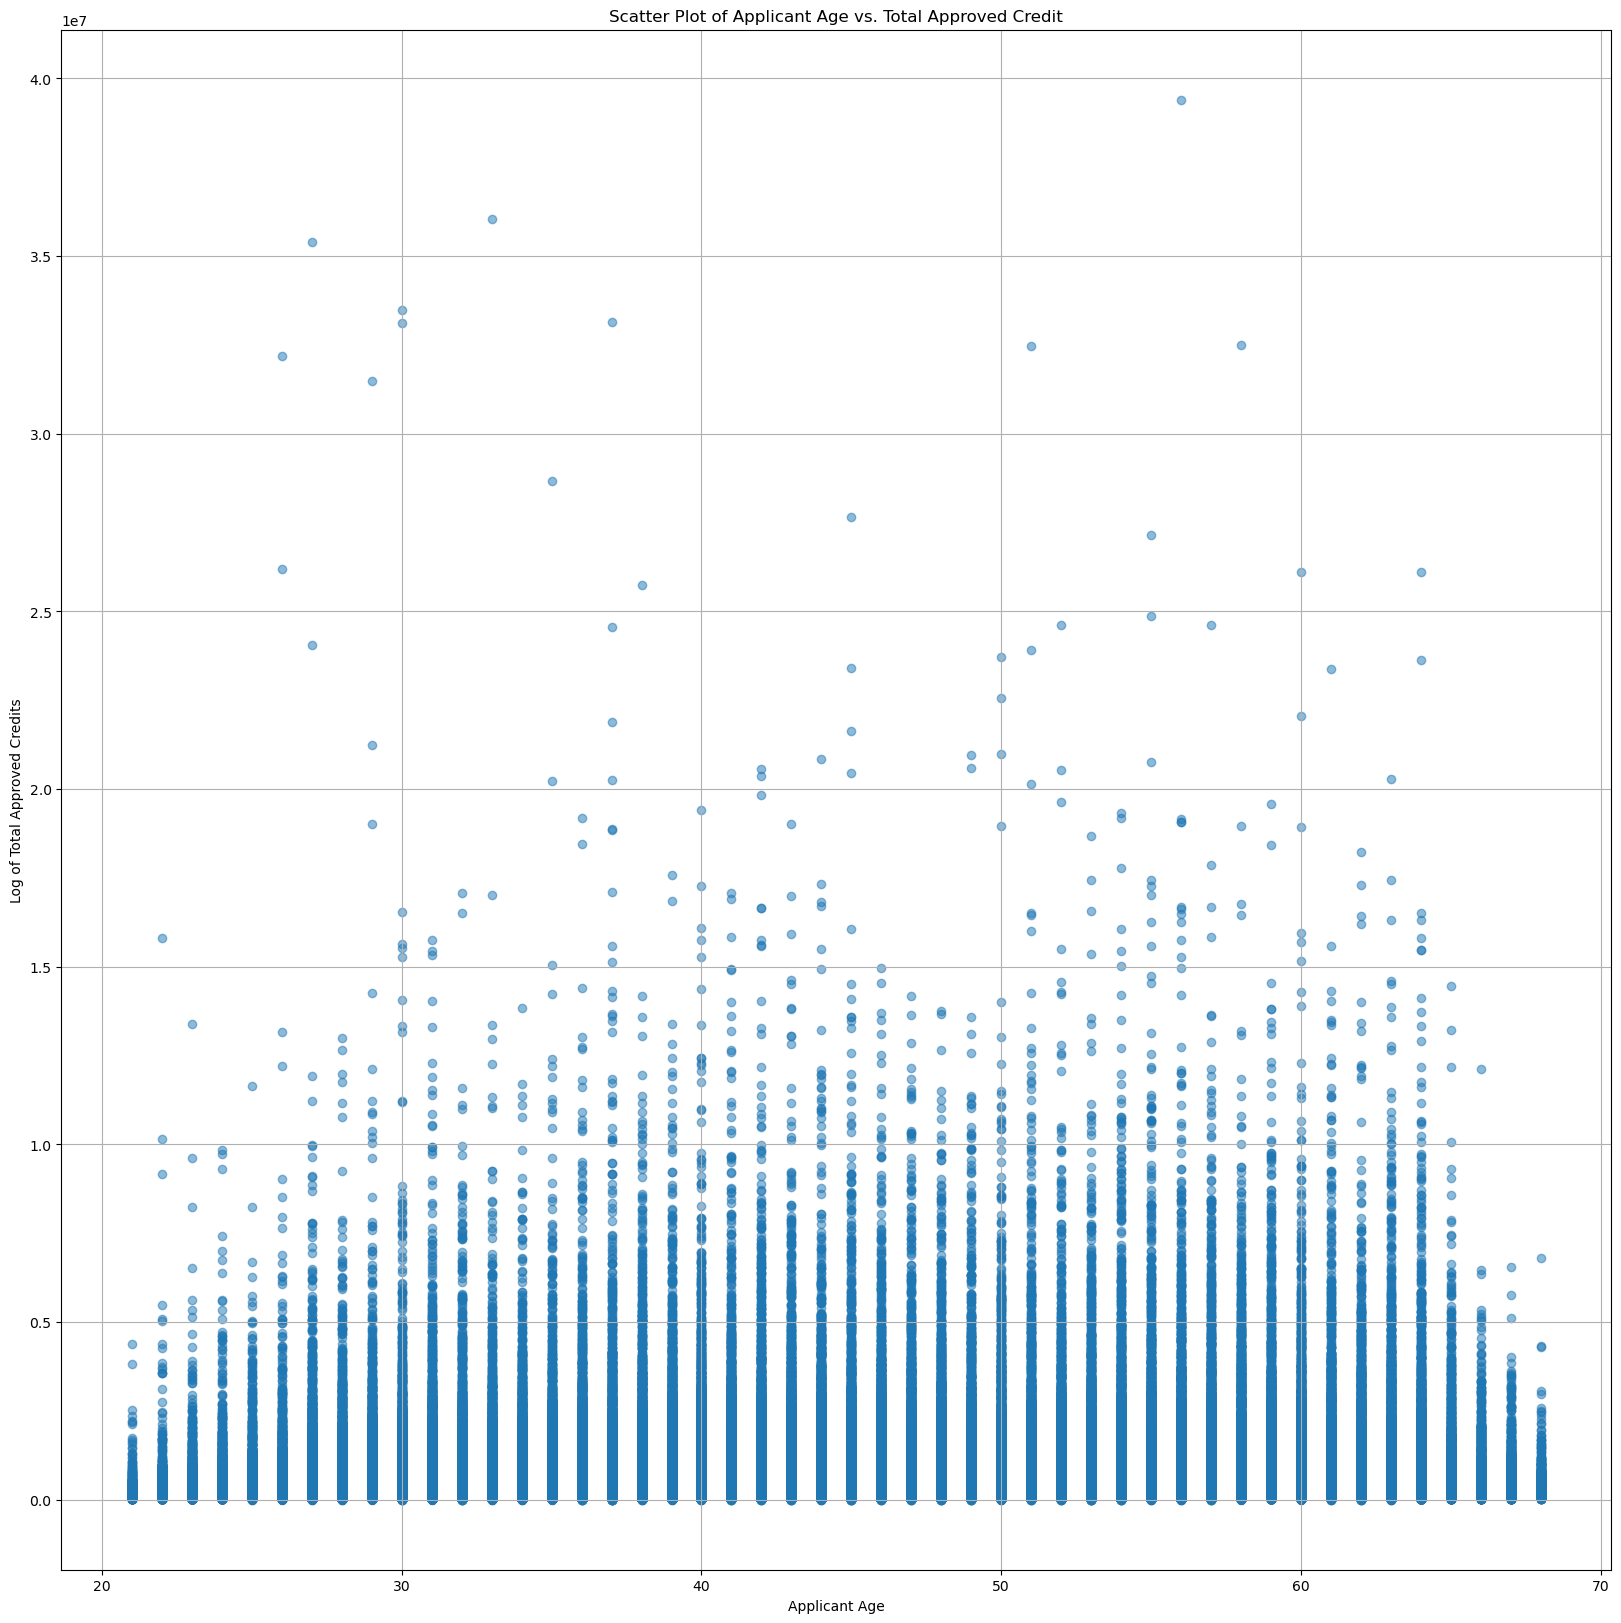

In [116]:
from pyspark.sql.functions import log
# df_joined.printSchema()
# Calculating Total Amount Credit 
aggregated_credit_df = df_previous_application.groupBy("id_app")\
.agg(sum("amt_credit").alias("total_amt_credit"))

# Joining above dataframe with age data to get age values
aggregated_credit_df = aggregated_credit_df.join(df_age_data, \
    aggregated_credit_df.id_app == df_age_data.id_app ,how="inner")

# Grouping data by id and age
aggregated_credit_df = aggregated_credit_df.groupBy(df_age_data\
["id_app"],"age").agg((sum(aggregated_credit_df.total_amt_credit))\
                      .alias("final_amt_credit"))

# Collecting Plotting data
plot_data = aggregated_credit_df.select("age", "final_amt_credit")\
.collect()

# Extracting Lists for plotting graph
ages = [row["age"] for row in plot_data]
credits = [row["final_amt_credit"] for row in plot_data]

#Plotting Graph
plt.figure(figsize=(20, 20))
plt.scatter(ages, credits, alpha=0.5)
plt.xlabel("Applicant Age")
plt.ylabel("Log of Total Approved Credits")
plt.title("Scatter Plot of Applicant Age vs. Total Approved Credit")
plt.grid(True)
plt.show()


### Part 3 RDDs vs DataFrame vs Spark SQL  <a class="anchor" name="part-3"></a>
Here we compare the performance of RDDs, DataFrames and Spark SQL. We implement the following queries using RDDs, DataFrames in SparkSQL separately. Log the time taken for each query in each approach  and discuss the performance difference between these three approaches.


#### Complex Query (high-risk applicants): Find the top 100 applicants who are married with children and have a total approved credit that is more than five times their incomes (regardless of any payments made), sorted by the total credit/income ratio. 

#### 3.1. RDD Implementation

In [123]:
%%time 

# Joining both dataframes
combined_data = df_application_data.join(df_previous_application, df_application_data.id_app == df_previous_application.id_app)

# COnverting dataframe into RDD
combined_data_rdd = combined_data.rdd.map(list)

# FIltering RDD based on family and childrens
filtered_rdd = combined_data_rdd.filter(lambda x: x[13] in \
                                ['2','3'] and int(x[6])>0)

# Extracting required fields
id_amt_income_only = filtered_rdd.map(lambda x: (x[0], float(x[8]), \
                                            float(x[7])))
# Function to calculate income ratio
def extract_credit_income_ratio(row):
    return (row[0], row[1]/row[2])

# Adding income ratio to RDD
key_value_rdd = id_amt_income_only.map(extract_credit_income_ratio)

# Reducing to get total Ratio
final_rdd = key_value_rdd.reduceByKey(lambda x, y: x + y)

# Filtering for ratio values > 5
final = final_rdd.filter(lambda x: x[1]>5)
# final_rdd = final_rdd.sortBy(lambda x: x[1]).collect()

# Displaying output
final.take(100)



CPU times: user 21.8 ms, sys: 153 µs, total: 22 ms
Wall time: 16.6 s


[('100208', 19.752),
 ('100226', 9.6),
 ('101900', 5.00385),
 ('102207', 47.22222222222222),
 ('106563', 26.6464),
 ('106775', 13.713257142857142),
 ('108464', 22.9354),
 ('109715', 31.23357142857143),
 ('110773', 7.9008),
 ('112261', 7.112),
 ('113727', 23.863),
 ('114671', 21.54624),
 ('114803', 13.333333333333334),
 ('115379', 30.0),
 ('115713', 15.348837209302326),
 ('117296', 11.428571428571429),
 ('117902', 6.218333333333334),
 ('119600', 11.166666666666668),
 ('120950', 8.810550000000001),
 ('121071', 9.584),
 ('125702', 60.47567567567568),
 ('126020', 9.03555),
 ('130365', 28.266666666666666),
 ('132637', 47.833333333333336),
 ('134202', 68.52650000000001),
 ('135509', 10.15872),
 ('135698', 14.56128),
 ('136100', 25.64894117647059),
 ('139038', 101.70857142857143),
 ('139362', 22.0),
 ('140289', 32.5),
 ('148068', 8.88888888888889),
 ('148875', 12.5),
 ('152798', 39.03771428571429),
 ('159937', 24.961304347826083),
 ('160088', 27.98688),
 ('166391', 18.613333333333333),
 ('169

#### 3.2. DataFrame Implementation

In [124]:
%%time
from pyspark.sql.functions import ceil, col, when, count, sum

# Joining the tables based on Id_app
combined_data = df_application_data.join(df_previous_application, \
df_application_data.id_app == df_previous_application.id_app)

# Grouping data and calculating total amount credit
combined_data = combined_data.groupBy(df_application_data["id_app"]).\
agg(sum(df_previous_application["amt_credit"]).alias("total_amt_credit"))

# Joining with application data to get family and children data
combined_data = combined_data.join(df_application_data, "id_app")

# Caluclating credit income ratio
combined_data = combined_data.withColumn("credit_income_ratio", \
                    (col("total_amt_credit")/col("income_total")))

# Filtering based on required criterias
df_credit_final = combined_data.filter((col("num_of_children")>0) \
    & ((col("credit_income_ratio"))>"5") & ((col("family_status")=="2") \
    | (col("family_status")=="3") )).orderBy("credit_income_ratio", \
                                        ascending=False).limit(100)

# Displaying output
df_credit_final.select("id_app", "family_status","num_of_children", \
        "total_amt_credit", "income_total", "credit_income_ratio").show(100)

+------+-------------+---------------+-----------------+------------+-------------------+
|id_app|family_status|num_of_children| total_amt_credit|income_total|credit_income_ratio|
+------+-------------+---------------+-----------------+------------+-------------------+
|197725|            3|              2|      2.8667205E7|    144000.0|        199.0778125|
|200698|            3|              1|     2.46144555E7|    126000.0| 195.35282142857142|
|104007|            3|              2|     1.18949625E7|     72000.0|        165.2078125|
|191956|            3|              1|     1.68350895E7|    112500.0|          149.64524|
|270489|            3|              1|     1.56507525E7|    112428.0| 139.20689241114314|
|164657|            3|              1|       1.181394E7|     90000.0|            131.266|
|193609|            3|              1|     1.42753005E7|    112500.0|          126.89156|
|291238|            3|              1|      1.1088486E7|     90000.0|           123.2054|
|256557|  

#### 3.3. Spark SQL Implementation

In [125]:
%%time
from pyspark.sql import SparkSession # Spark SQL

# Create Views from Dataframes
df_application_data.createOrReplaceTempView("sql_app_data")
df_previous_application.createOrReplaceTempView("sql_prev_app_data")

# Spark SQL query
sql_dict_inner_summ = spark.sql('''
  SELECT app.id_app, app.family_status, app.num_of_children, app.income_total, 
  SUM(prev.amt_credit) AS total_credit, (SUM(prev.amt_credit) / app.income_total) 
  AS credit_income_ratio
  FROM sql_app_data app
  JOIN sql_prev_app_data prev ON app.id_app = prev.id_app
  WHERE app.family_status IN (2,3) AND app.num_of_children>0
  GROUP BY app.id_app, app.family_status, app.num_of_children, app.income_total
  HAVING (SUM(prev.amt_credit) / app.income_total)>5
  ORDER BY credit_income_ratio DESC
  LIMIT 100
''')

print(sql_dict_inner_summ.count())
sql_dict_inner_summ.show(100)

100
+------+-------------+---------------+------------+-----------------+-------------------+
|id_app|family_status|num_of_children|income_total|     total_credit|credit_income_ratio|
+------+-------------+---------------+------------+-----------------+-------------------+
|197725|            3|              2|    144000.0|      2.8667205E7|        199.0778125|
|200698|            3|              1|    126000.0|     2.46144555E7| 195.35282142857142|
|104007|            3|              2|     72000.0|     1.18949625E7|        165.2078125|
|191956|            3|              1|    112500.0|     1.68350895E7|          149.64524|
|270489|            3|              1|    112428.0|     1.56507525E7| 139.20689241114314|
|164657|            3|              1|     90000.0|       1.181394E7|            131.266|
|193609|            3|              1|    112500.0|     1.42753005E7|          126.89156|
|291238|            3|              1|     90000.0|      1.1088486E7|           123.2054|
|25655

The fastest are DataFrame closely followed by SQL. This is because RDDs are more primitive. They offer more felxibility with the trade off being higher complexity and performance times. The Catalytic optimization and bytecode generation offered by the Dataframes and SQLs helps improve performance and simplifies the usability of Dataframes and SparkSQL. Moreover SQL syntaxes may be more familiar for those with SQL experience or RDBMS experience making SQL a more user friendly option. Whereas the wide variety of packages and functions supported by Dataframe makes data manipulation and wrangling easier. It also supports a wide variety of functionalities and can be used easily by any novice. RDD on the other hand is as bare bones as it gets. RDDswill require more lines of code than Dataframes or SParkSQL for similar functions as it requires more inputs and instructions. Overall, Dataframes and SparkSQL provide more programming support and performance making it a better choice for various spark operations. However, for certain scenarios where extreme flexibility and programming manoeuvrability may be required, RDD would be more apt. Please find below comparison of run times of RDD, Dataframes and SParkSQL.

#### Summary

The time might differ when running on different machines. Overall, the DataFrame and SQL queries run faster compared with RDD.

<table>
    <tr>
        <th>RDD</th>
        <th>DataFrame</th>
        <th>SQL</th>
    </tr>
    <tr>
        <td>16.7s</td>
        <td>2.3s</td>
        <td>2.5s</td>
    </tr>
    <tr>
        <td>16.9s</td>
        <td>2.2s</td>
        <td>2.6s</td>
    </tr>
    <tr>
        <td>17.7s</td>
        <td>2.5s</td>
        <td>2.7s</td>
    </tr>
    <tr>
        <td>17.7s</td>
        <td>2.1s</td>
        <td>2.3s</td>
    </tr>
    <tr>
        <td>17.3s</td>
        <td>1.9s</td>
        <td>2.2s</td>
    </tr>
    <tr>
        <td>17.1s</td>
        <td>2.4s</td>
        <td>2.7s</td>
    </tr>
    <tr>
        <td>17.3s</td>
        <td>2.5s</td>
        <td>2.4s</td>
    </tr>
</table>